# Goal

* Creating wrapper functions for simulating a gradient with SIPSim
  * will help to run multiple gradients through pipeline
  * also will help to try differing params for validation

## Input parameters
  * phyloseq.bulk file 
  * taxon mapping file
  * list of genomes
  * fragments simulated for all genomes
  * bulk community richness


## workflow

* Creating a community file from OTU abundances in bulk soil samples
  * phyloseq.bulk --> OTU table --> filter to sample --> community table format
* Fragment simulation
  * simulated_fragments --> parse out fragments for target OTUs 
  * simulated_fragments --> parse out fragments from random genomes to obtain richness of interest
  * combine fragment python objects
* Convert fragment lists to kde object
* Add diffusion
* Make incorp config file
* Add isotope incorporation
* Calculating BD shift from isotope incorp
* Simulating gradient fractions
* Simulating OTU table
* Simulating PCR
* Subsampling from the OTU table
* Adding count error

# Possible methods for validation

## Number of taxa 

* Create BD range interval
* For each BD range interval:
  * Weighted mean of number of taxa for actual and simulated
  * Calculate pearsons correlation coef
 
## Center & distribution of mass 

* [CSIP center of mass notebook](https://github.com/chuckpr/CSIP_succession_data_analysis/blob/master/figures_and_stats/OTU_density_shifts.ipynb)
  * see wavg() function
* [interpolating compositional data](https://www.researchgate.net/post/Interpolating_compositional_data_ie_soil_particle_size_fraction/1)


* For each taxon:
  * Calculate center of mass BD value
  * Calculate distribution of mass (95%) for BD values
  
  

## Init

In [1]:
import os
import glob
import cPickle as pickle
import copy
import re
import nestly

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)
library(phyloseq)

## BD for G+C of 0 or 100
BD.GCp0 = 0 * 0.098 + 1.66
BD.GCp100 = 1 * 0.098 + 1.66

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)


# Nestly

* assuming fragments already simulated

In [57]:
workDir = '/home/nick/notebook/SIPSim/dev/fullCyc/frag_norm_9_2.5_n5'
buildDir = os.path.join(workDir, 'default_run')
R_dir = '/home/nick/notebook/SIPSim/lib/R/'

fragFile= os.path.join(workDir, 'ampFrags.pkl')
targetFile = '/home/nick/notebook/SIPSim/dev/fullCyc/CD-HIT/target_taxa.txt'

physeqDir = '/var/seq_data/fullCyc/MiSeq_16SrRNA/515f-806r/lib1-7/phyloseq/'
physeq_bulkCore = 'bulk-core'
physeq_SIP_core = 'SIP-core_unk'

bulk_days = [1]

seq_per_fraction = ['lognormal', 9.432, 0.5, 10000, 80000] # dist, mean, scale, min, max
nprocs = 30

In [53]:
# building tree structure
nest = nestly.Nest()

## varying params
nest.add('bulk_day', bulk_days)

## set params
nest.add('percIncorp', [0], create_dir=False)
nest.add('percTaxa', [0], create_dir=False)
nest.add('np', [nprocs], create_dir=False)
nest.add('abs', ['5e9'], create_dir=False)
nest.add('subsample_dist', [seq_per_fraction[0]], create_dir=False)
nest.add('subsample_mean', [seq_per_fraction[1]], create_dir=False)
nest.add('subsample_scale', [seq_per_fraction[2]], create_dir=False)
nest.add('subsample_min', [seq_per_fraction[3]], create_dir=False)
nest.add('subsample_max', [seq_per_fraction[4]], create_dir=False)

### input/output files
nest.add('buildDir', [buildDir], create_dir=False)
nest.add('R_dir', [R_dir], create_dir=False)
nest.add('fragFile', [fragFile], create_dir=False)
nest.add('targetFile', [targetFile], create_dir=False)
nest.add('physeqDir', [physeqDir], create_dir=False)
nest.add('physeq_bulkCore', [physeq_bulkCore], create_dir=False)


# building directory tree
nest.build(buildDir)

# bash file to run
bashFile = os.path.join(buildDir, 'SIPSimRun.sh')

In [54]:
%%writefile $bashFile
#!/bin/bash

export PATH={R_dir}:$PATH

#-- making DNA pool similar to gradient of interest
echo '# Creating comm file from phyloseq'
phyloseq2comm.r {physeqDir}{physeq_bulkCore} -s 12C-Con -d {bulk_day} > {physeq_bulkCore}_comm.txt
printf 'Number of lines: '; wc -l {physeq_bulkCore}_comm.txt

echo '## Adding target taxa to comm file'
comm_add_target.r {physeq_bulkCore}_comm.txt {targetFile} > {physeq_bulkCore}_comm_target.txt
printf 'Number of lines: '; wc -l {physeq_bulkCore}_comm_target.txt

echo '## parsing out genome fragments to make simulated DNA pool resembling the gradient of interest'
## all OTUs without an associated reference genome will be assigned a random reference (of the reference genome pool)
### this is done through --NA-random
SIPSim fragment_KDE_parse {fragFile} {physeq_bulkCore}_comm_target.txt \
    --rename taxon_name --NA-random > fragsParsed.pkl


echo '#-- SIPSim pipeline --#'
echo '# converting fragments to KDE'
SIPSim fragment_KDE \
    fragsParsed.pkl \
    > fragsParsed_KDE.pkl
    
echo '# adding diffusion'    
SIPSim diffusion \
    fragsParsed_KDE.pkl \
    --np {np} \
    > fragsParsed_KDE_dif.pkl    
    
echo '# making incorp file'
SIPSim incorpConfigExample \
  --percTaxa {percTaxa} \
  --percIncorpUnif {percIncorp} \
  > {percTaxa}_{percIncorp}.config

echo '# adding isotope incorporation to BD distribution'
SIPSim isotope_incorp \
    fragsParsed_KDE_dif.pkl \
    {percTaxa}_{percIncorp}.config \
    --comm {physeq_bulkCore}_comm_target.txt \
    --np {np} \
    > fragsParsed_KDE_dif_inc.pkl
 
#echo '# calculating BD shift from isotope incorporation'
#SIPSim BD_shift \
#    fragsComb.pkl \
#    fragsComb_incorp.pkl \
#    --np {np} \
#    > fragsComb_incorp_BD-shift.txt

echo '# simulating gradient fractions'
SIPSim gradient_fractions \
    {physeq_bulkCore}_comm_target.txt \
    > fracs.txt 

echo '# simulating an OTU table'
SIPSim OTU_table \
    fragsParsed_KDE_dif_inc.pkl \
    {physeq_bulkCore}_comm_target.txt \
    fracs.txt \
    --abs {abs} \
    --np {np} \
    > OTU_abs{abs}.txt
    
echo '# simulating PCR'
SIPSim OTU_PCR \
    OTU_abs{abs}.txt \
    > OTU_abs{abs}_PCR.txt    
    
echo '# subsampling from the OTU table (simulating sequencing of the DNA pool)'
SIPSim OTU_subsample \
    --dist {subsample_dist} \
    --dist_params mean:{subsample_mean},sigma:{subsample_scale} \
    --min_size {subsample_min} \
    --max_size {subsample_max} \
    OTU_abs{abs}_PCR.txt \
    > OTU_abs{abs}_PCR_sub.txt
    
echo '# adding count error'
SIPSim OTU_add_error \
    OTU_abs{abs}_PCR_sub.txt \
    > OTU_abs{abs}_PCR_sub_negBin.txt 
    
echo '# making a wide-formatted table'
SIPSim OTU_wideLong -w \
    OTU_abs{abs}_PCR_sub_negBin.txt \
    > OTU_abs{abs}_PCR_sub_negBin_w.txt
    
echo '# making metadata (phyloseq: sample_data)'
SIPSim OTU_sampleData \
    OTU_abs{abs}_PCR_sub_negBin.txt \
    > OTU_abs{abs}_PCR_sub_negBin_meta.txt

Writing /home/nick/notebook/SIPSim/dev/fullCyc/frag_norm_9_2.5_n5/default_run/SIPSimRun.sh


In [55]:
!chmod 777 $bashFile
!cd $workDir; \
    nestrun  --template-file $bashFile -d default_run --log-file log.txt

2015-12-01 14:23:10,576 * INFO * Template: ./SIPSimRun.sh
2015-12-01 14:23:10,578 * INFO * [30019] Started ./SIPSimRun.sh in default_run/1
2015-12-01 14:49:31,727 * INFO * [30019] default_run/1 Finished with 0


## Plotting number of taxa in each fraction

In [76]:
%%R -i physeqDir -i physeq_SIP_core -i bulk_days

# bulk core samples
F = file.path(physeqDir, physeq_SIP_core)
physeq.SIP.core = readRDS(F) 
physeq.SIP.core.m = physeq.SIP.core %>% sample_data

physeq.SIP.core = prune_samples(physeq.SIP.core.m$Substrate == '12C-Con' & 
                                physeq.SIP.core.m$Day %in% bulk_days, 
                                physeq.SIP.core) %>%
    filter_taxa(function(x) sum(x) > 0, TRUE)
physeq.SIP.core.m = physeq.SIP.core %>% sample_data        

physeq.SIP.core

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 7025 taxa and 25 samples ]
sample_data() Sample Data:       [ 25 samples by 17 sample variables ]
tax_table()   Taxonomy Table:    [ 7025 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 7025 tips and 7024 internal nodes ]


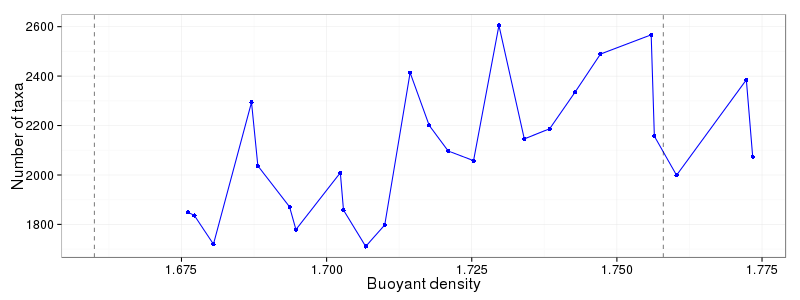

In [77]:
%%R -w 800 -h 300 

## dataframe
df.OTU = physeq.SIP.core %>% otu_table %>%
    as.matrix %>% as.data.frame
df.OTU$OTU = rownames(df.OTU)
df.OTU = df.OTU %>%    
    gather(sample, abundance, 1:(ncol(df.OTU)-1)) %>%
    group_by(sample) %>%
    summarize(n_taxa = sum(abundance > 0)) %>%
    ungroup()

df.OTU.real = inner_join(df.OTU, physeq.SIP.core.m, c('sample' = 'X.Sample')) 

## plotting
p = ggplot(df.OTU.real, aes(Buoyant_density, n_taxa)) +
    geom_point(color='blue') +
    geom_line(color='blue') +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density', y='Number of taxa') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p

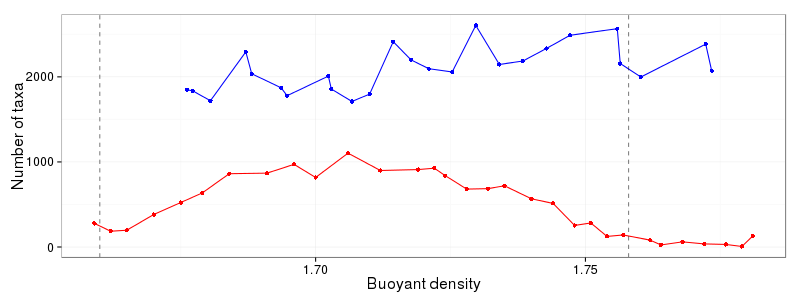

In [82]:
%%R -w 800 -h 300
OTU.table.dir = '/home/nick/notebook/SIPSim/dev/fullCyc/frag_norm_9_2.5_n5/default_run/1/'
OTU.table.file = 'OTU_abs5e9_PCR_sub_negBin.txt'

# loading file
F = file.path(OTU.table.dir, OTU.table.file)
df.OTU = read.delim(F, sep='\t')

## edit table
df.OTU.nt = df.OTU %>%
    filter(count > 0) %>%
    group_by(library, BD_mid) %>%
    summarize(n_taxa = n())

## plot
p = ggplot(df.OTU.nt, aes(BD_mid, n_taxa)) +
    geom_point(color='red') +
    geom_line(color='red') +
    geom_point(data=df.OTU.real, aes(x=Buoyant_density), color='blue') +
    geom_line(data=df.OTU.real, aes(x=Buoyant_density), color='blue') +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density', y='Number of taxa') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p

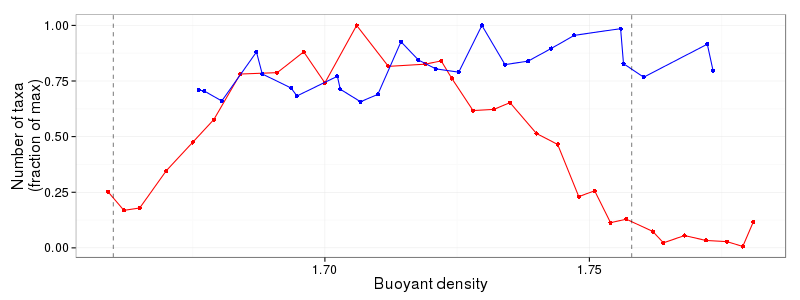

In [83]:
%%R -w 800 -h 300
# normalized by max number of taxa

## edit table
df.OTU.nt = df.OTU.nt %>%
    group_by() %>%
    mutate(n_taxa_norm = n_taxa / max(n_taxa))

df.OTU.real = df.OTU.real %>%
    group_by() %>%
    mutate(n_taxa_norm = n_taxa / max(n_taxa))


## plot
p = ggplot(df.OTU.nt, aes(BD_mid, n_taxa_norm)) +
    geom_point(color='red') +
    geom_line(color='red') +
    geom_point(data=df.OTU.real, aes(x=Buoyant_density), color='blue') +
    geom_line(data=df.OTU.real, aes(x=Buoyant_density), color='blue') +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density', y='Number of taxa\n(fraction of max)') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p

# Determining the pre-fractionation abundances of taxa in each gradient fraction

* low-abundant taxa out at the tails?
* OR broad distributions of high abundant taxa

In [109]:
%%R
physeq.SIP.core

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 7025 taxa and 25 samples ]
sample_data() Sample Data:       [ 25 samples by 17 sample variables ]
tax_table()   Taxonomy Table:    [ 7025 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 7025 tips and 7024 internal nodes ]


In [114]:
%%R
physeq.SIP.core.n = transform_sample_counts(physeq.SIP.core, function(x) x/sum(x))
physeq.SIP.core.n

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 7025 taxa and 25 samples ]
sample_data() Sample Data:       [ 25 samples by 17 sample variables ]
tax_table()   Taxonomy Table:    [ 7025 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 7025 tips and 7024 internal nodes ]


In [118]:
%%R
physeq.dir = '/var/seq_data/fullCyc/MiSeq_16SrRNA/515f-806r/lib1-7/phyloseq/'
physeq.bulk = 'bulk-core'
physeq.file = file.path(physeq.dir, physeq.bulk)
physeq.bulk = readRDS(physeq.file)
physeq.bulk.m = physeq.bulk %>% sample_data
physeq.bulk = prune_samples(physeq.bulk.m$Exp_type == 'microcosm_bulk' &
                            physeq.bulk.m$Day %in% bulk_days, physeq.bulk)

physeq.bulk.m = physeq.bulk %>% sample_data
physeq.bulk

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4950 taxa and 1 samples ]
sample_data() Sample Data:       [ 1 samples by 17 sample variables ]
tax_table()   Taxonomy Table:    [ 4950 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4950 tips and 4949 internal nodes ]


In [119]:
%%R
physeq.bulk.n = transform_sample_counts(physeq.bulk, function(x) x/sum(x))
physeq.bulk.n

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4950 taxa and 1 samples ]
sample_data() Sample Data:       [ 1 samples by 17 sample variables ]
tax_table()   Taxonomy Table:    [ 4950 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4950 tips and 4949 internal nodes ]


In [136]:
%%R
# making long format of SIP OTU table
SIP.otu = physeq.SIP.core.n %>% otu_table %>% as.data.frame
ncol = ncol(SIP.otu)
SIP.otu$OTU = rownames(SIP.otu)
SIP.otu = SIP.otu %>%
    gather(sample, abundance, 1:ncol) 

SIP.otu = inner_join(physeq.SIP.core.m, SIP.otu, c('X.Sample' = 'sample')) %>%
    select(-core_dataset, -Sample_location, -Sample_date, -Sample_treatment,
           -Sample_subtreatment, -library, -Sample_type)
SIP.otu %>% head(n=3)

           X.Sample primer_number fwd_barcode rev_barcode Substrate Day
1 12C-Con.D1.R2_F23           134    TCGACGAG    TGAGTACG   12C-Con   1
2 12C-Con.D1.R2_F23           134    TCGACGAG    TGAGTACG   12C-Con   1
3 12C-Con.D1.R2_F23           134    TCGACGAG    TGAGTACG   12C-Con   1
  Microcosm_replicate Fraction Buoyant_density Exp_type      OTU    abundance
1                   2       23         1.69362      SIP OTU.1101 0.0001485001
2                   2       23         1.69362      SIP OTU.1130 0.0000000000
3                   2       23         1.69362      SIP OTU.9833 0.0000000000


In [137]:
%%R
# making long format of each bulk table
bulk.otu = physeq.bulk.n %>% otu_table %>% as.data.frame
ncol = ncol(bulk.otu)
bulk.otu$OTU = rownames(bulk.otu)
bulk.otu = bulk.otu %>%
    gather(sample, abundance, 1:ncol) 

bulk.otu = inner_join(physeq.bulk.m, bulk.otu, c('X.Sample' = 'sample')) %>%
    select(OTU, abundance) %>%
    rename('bulk_abund' = abundance)
bulk.otu %>% head(n=3)

       OTU   bulk_abund
1 OTU.1101 1.234263e-04
2 OTU.1130 6.171316e-05
3 OTU.9833 0.000000e+00


In [138]:
%%R
# joining tables
SIP.otu = inner_join(SIP.otu, bulk.otu, c('OTU' = 'OTU'))
SIP.otu %>% head(n=3)

           X.Sample primer_number fwd_barcode rev_barcode Substrate Day
1 12C-Con.D1.R2_F23           134    TCGACGAG    TGAGTACG   12C-Con   1
2 12C-Con.D1.R2_F23           134    TCGACGAG    TGAGTACG   12C-Con   1
3 12C-Con.D1.R2_F23           134    TCGACGAG    TGAGTACG   12C-Con   1
  Microcosm_replicate Fraction Buoyant_density Exp_type      OTU    abundance
1                   2       23         1.69362      SIP OTU.1101 0.0001485001
2                   2       23         1.69362      SIP OTU.1130 0.0000000000
3                   2       23         1.69362      SIP OTU.9833 0.0000000000
    bulk_abund
1 1.234263e-04
2 6.171316e-05
3 0.000000e+00


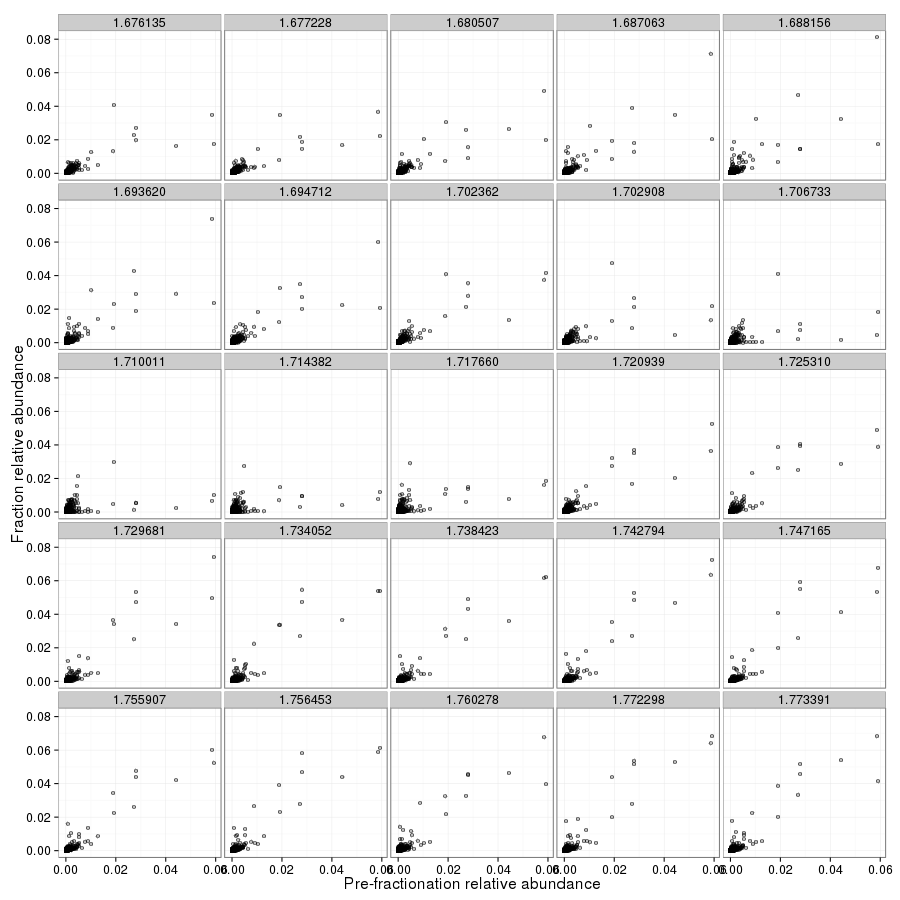

In [147]:
%%R -w 900 -h 900
# for each gradient, plotting gradient rel_abund vs bulk rel_abund

ggplot(SIP.otu, aes(bulk_abund, abundance)) +
    geom_point(alpha=0.2) +
    geom_point(shape='O', alpha=0.6) +
    facet_wrap(~ Buoyant_density) +
    labs(x='Pre-fractionation relative abundance', 
         y='Fraction relative abundance') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

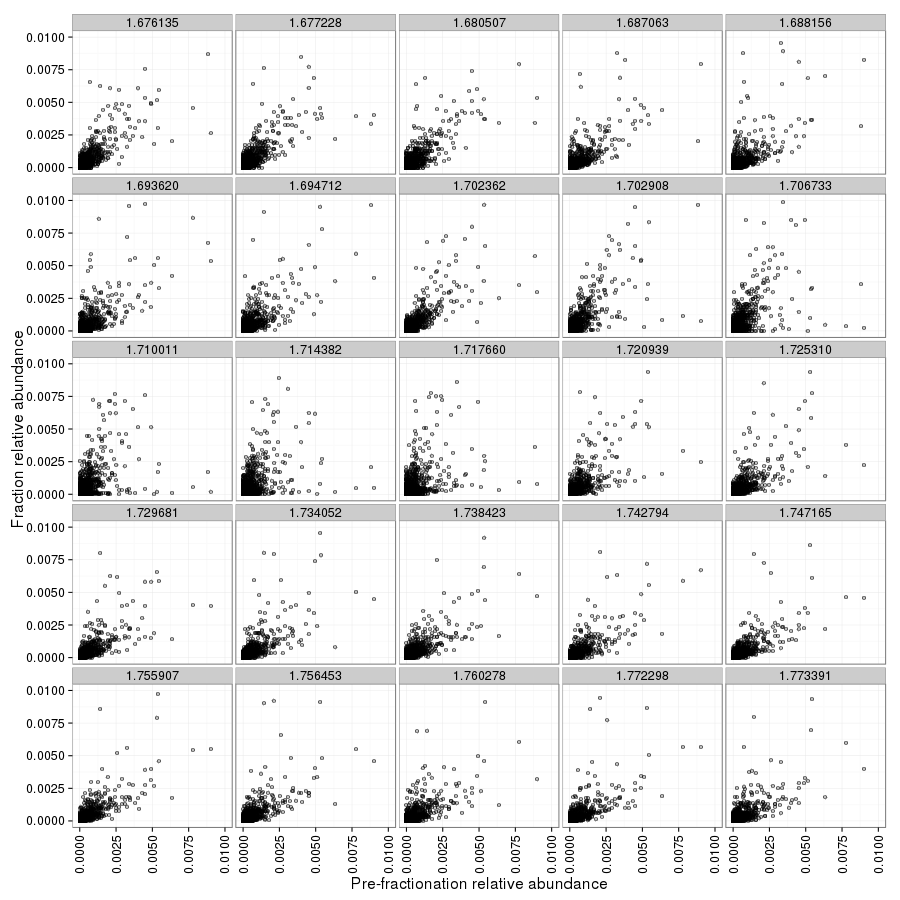

In [152]:
%%R -w 900 -h 900
# for each gradient, plotting gradient rel_abund vs bulk rel_abund

ggplot(SIP.otu, aes(bulk_abund, abundance)) +
    geom_point(alpha=0.2) +
    geom_point(shape='O', alpha=0.6) +
    scale_x_continuous(limits=c(0,0.01)) +
    scale_y_continuous(limits=c(0,0.01)) +
    facet_wrap(~ Buoyant_density) +
    labs(x='Pre-fractionation relative abundance', 
         y='Fraction relative abundance') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=90, hjust=1, vjust=0.5)
    )

## Plotting distributions of each taxon across gradients

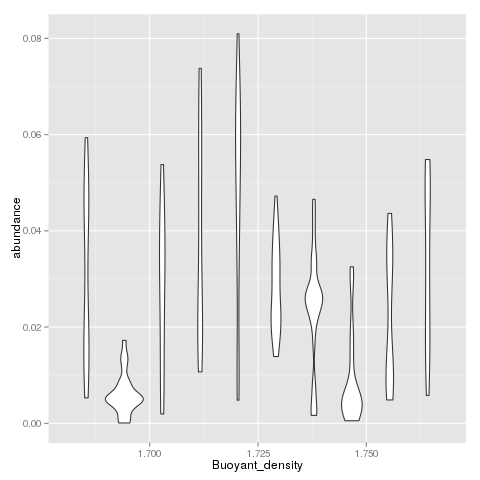

In [166]:
%%R
# filtering to most abundant bulk OTUs
tmp = bulk.otu %>%
    mutate(rank = row_number(-bulk_abund)) %>%
    filter(rank <= 10)

SIP.otu.f = SIP.otu %>%
    filter(OTU %in% tmp$OTU) 

ggplot(SIP.otu.f, aes(Buoyant_density, abundance, group=OTU)) +
    geom_violin()
# TODO

## Plotting the abundance distribution of top 10 most abundant taxa (bulk samples) 

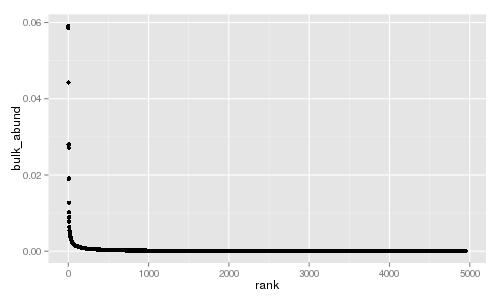

In [169]:
%%R -w 500 -h 300
# checking bulk rank-abundance
tmp = bulk.otu %>%
    mutate(rank = row_number(-bulk_abund))

ggplot(tmp, aes(rank, bulk_abund)) +
    geom_point()

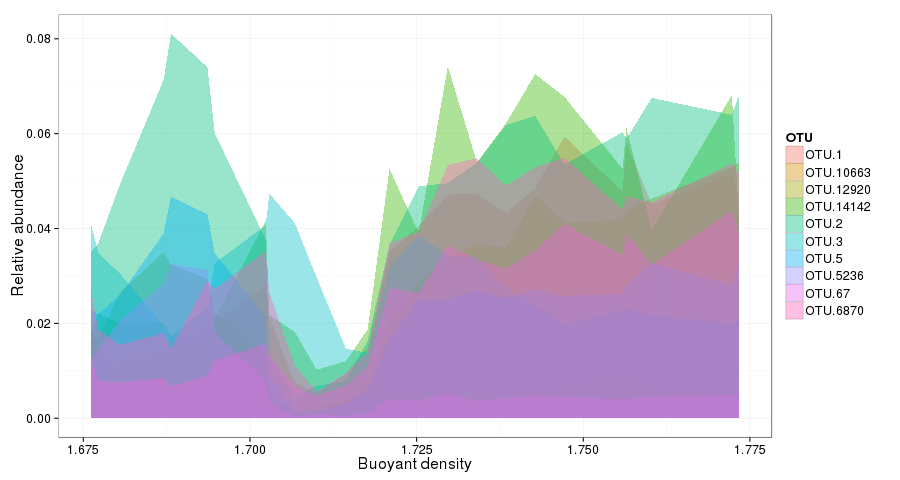

In [183]:
%%R -w 900
top.n = filter(tmp, rank <= 10)
SIP.otu.f = SIP.otu %>%
    filter(OTU %in% top.n$OTU) 

ggplot(SIP.otu.f, aes(Buoyant_density, abundance, group=OTU, fill=OTU)) +
    #geom_point() +
    #geom_line() +
    geom_area(position='dodge', alpha=0.4) +
    labs(y='Relative abundance', x='Buoyant density') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

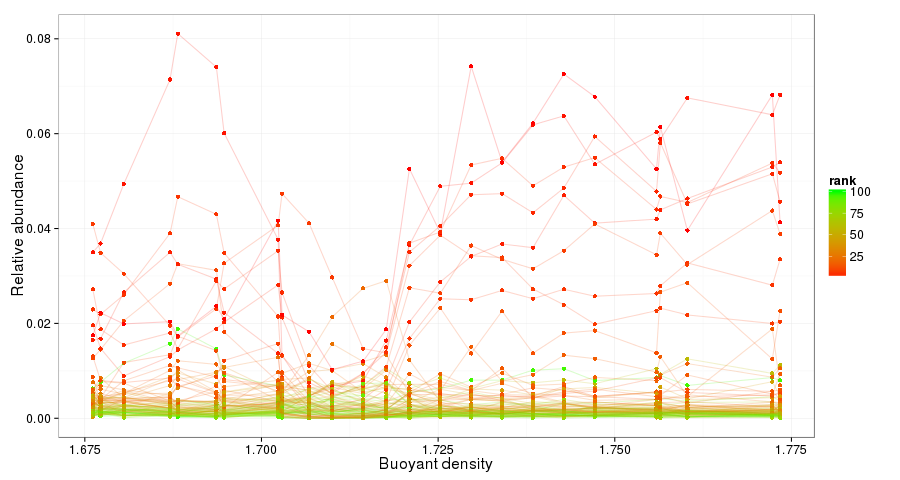

In [186]:
%%R -w 900
top.n = filter(tmp, rank <= 100)

SIP.otu.f = inner_join(SIP.otu, top.n, c('OTU' = 'OTU'))
#SIP.otu %>%
    #filter(OTU %in% top.n$OTU) 

ggplot(SIP.otu.f, aes(Buoyant_density, abundance, group=OTU, color=rank)) +
    geom_point() +
    geom_line(alpha=0.2) +
    scale_color_continuous(low='red', high='green') +
    labs(y='Relative abundance', x='Buoyant density') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

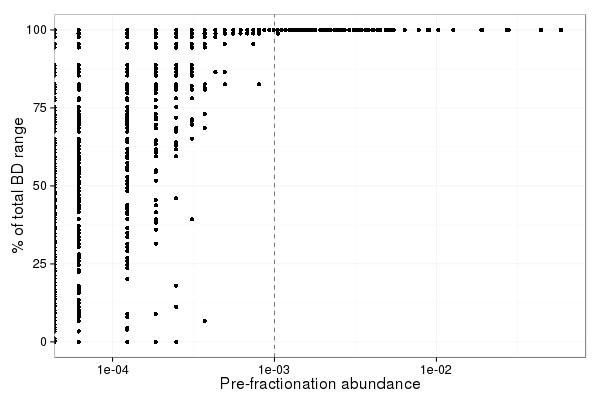

In [209]:
%%R -w 600 -h 400
# Number of gradients that each OTU is found in

max_BD_range = max(SIP.otu$Buoyant_density) - min(SIP.otu$Buoyant_density)

SIP.otu.f = SIP.otu %>%
    filter(abundance > 0) %>%
    group_by(OTU) %>%
    summarize(bulk_abund = mean(bulk_abund),
              min_BD = min(Buoyant_density),
              max_BD = max(Buoyant_density),
              BD_range = max_BD - min_BD,
              BD_range_perc = BD_range / max_BD_range * 100) %>%
    ungroup() 


ggplot(SIP.otu.f, aes(bulk_abund, BD_range_perc, group=OTU)) +
    geom_point() +
    scale_x_log10() +
    labs(x='Pre-fractionation abundance', y='% of total BD range') +
    geom_vline(xintercept=0.001, linetype='dashed', alpha=0.5) +
    theme_bw() +
    theme(
        text = element_text(size=16)
        )
    

In [ ]:
%%R


 # OLD

## Mapping bulk and fraction OTUs

In [85]:
%%R
physeqDir = '/var/seq_data/fullCyc/MiSeq_16SrRNA/515f-806r/lib1-7/phyloseq/'
physeq_bulkCore = 'bulk-SIP-core'
physeq.file = file.path(physeqDir, physeq_bulkCore)
physeq = readRDS(physeq.file)
physeq.m = physeq %>% sample_data
physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 12465 taxa and 1018 samples ]
sample_data() Sample Data:       [ 1018 samples by 17 sample variables ]
tax_table()   Taxonomy Table:    [ 12465 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 12465 tips and 12464 internal nodes ]


In [100]:
%%R -i bulk_days
# parsing out just bulk & SIP samples of interest
physeq.f = prune_samples((physeq.m$Exp_type == 'microcosm_bulk' &
                          physeq.m$Day %in% bulk_days) | 
                         (physeq.m$Exp_type == 'SIP' & 
                          physeq.m$Day %in% bulk_days & 
                          physeq.m$Substrate == '12C-Con'),
                         physeq) %>% 
    filter_taxa(function(x) sum(x) > 0, TRUE)
physeq.f.m = physeq.f %>% sample_data %>% as.matrix %>% as.data.frame 
physeq.f         

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 7097 taxa and 27 samples ]
sample_data() Sample Data:       [ 27 samples by 17 sample variables ]
tax_table()   Taxonomy Table:    [ 7097 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 7097 tips and 7096 internal nodes ]


In [103]:
%%R
# check of samples
physeq.f.m %>% 
    as.data.frame() %>%
    group_by(Exp_type, Day, Substrate) %>%
    summarize(n = n())

Source: local data frame [2 x 4]
Groups: Exp_type, Day [?]

        Exp_type    Day Substrate     n
          (fctr) (fctr)    (fctr) (int)
1 microcosm_bulk      1   12C-Con     1
2            SIP      1   12C-Con    26


## Are the high abundant taxa out at the tails?

In [ ]:
%%R
# parsing out high abundant taxa
prune_samples(physeq.f

# debug

In [207]:
#-- debug --#
SIPSim isotope_incorp fragsParsed.pkl 0_0.config --comm bulk-core_comm_target.txt 
    > fragsParsed_incorp.pkl
    
    
SIPSim fragment_kde_parse /home/nick/notebook/SIPSim/dev/fullCyc/frag_norm_9_2.5_n5/ampFrags.pkl bulk-core_comm_target.txt --rename taxon_name    


SIPSim OTU_subsample \
    --dist lognormal \
    --dist_params mean:9.432,sigma:0.5 \
    --min_size 10000 \
    --max_size 80000 \
    OTU_abs5e9_PCR.txt \
    > OTU_abs5e9_PCR_sub.txt

In [ ]:
# RESTART
!cd $workDir; rm -rf $buildDir

In [39]:
%%R 
#-- debug
df.id = read.delim('/home/nick/notebook/SIPSim/dev/fullCyc/frag_norm_9_2.5_n5/default_run/1/fragsParsed_IDs.txt', sep='\t', header=F)
df.comm = read.delim('/home/nick/notebook/SIPSim/dev/fullCyc/frag_norm_9_2.5_n5/default_run/1/bulk-core_comm_target.txt', sep='\t')

df.id %>% nrow %>% print
df.comm %>% nrow %>% print
inner_join(df.id, df.comm, c('V1' = 'taxon_name')) %>% nrow %>% print

[1] 2008
[1] 2008
[1] 2008


***
***
***

# Creating a community file from bulk soil sample

* will be used to determine community richness

### bulk-core samples

In [386]:
%%R -i physeq_dir -i physeq_bulkCore
# bulk core samples
F = file.path(physeq_dir, physeq_bulkCore)
physeq.bulk = readRDS(F)
physeq.bulk.m = physeq.bulk %>% sample_data
physeq.bulk

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4950 taxa and 9 samples ]
sample_data() Sample Data:       [ 9 samples by 17 sample variables ]
tax_table()   Taxonomy Table:    [ 4950 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4950 tips and 4949 internal nodes ]


In [387]:
%%R -i bulk_day
# just 12C-Con samples
physeq.bulk.12C = prune_samples(physeq.bulk.m$Substrate == '12C-Con' & 
                                physeq.bulk.m$Day == bulk_day, physeq.bulk) %>%
    filter_taxa(function(x) sum(x) > 0, TRUE)
physeq.bulk.12C.m = physeq.bulk.12C %>% sample_data
physeq.bulk.12C

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2008 taxa and 1 samples ]
sample_data() Sample Data:       [ 1 samples by 17 sample variables ]
tax_table()   Taxonomy Table:    [ 2008 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 2008 tips and 2007 internal nodes ]


In [389]:
%%R -i work_dir -i bulk_day

physeq2comm = function(physeq){
    df.otu = physeq %>% otu_table %>% as.matrix %>% as.data.frame
    df.otu$taxon_name = rownames(df.otu)
    df.otu = gather(df.otu, 'sample', 'abundance', 1:(ncol(df.otu)-1))
    df.otu = df.otu %>%
        group_by(sample) %>%
        mutate(rel_abund_perc = abundance / sum(abundance) * 100,
               rank = row_number(-abundance)) %>%
        ungroup() %>%
        mutate(library = gsub('^', '_', sample) %>% as.factor %>% as.numeric) %>%
        select(library, taxon_name, rel_abund_perc, rank) %>%
        arrange(library, rank)
    return(df.otu)
}

comm.bulk.12C = physeq2comm(physeq.bulk.12C)
cat('Community richness: ', comm.bulk.12C$taxon_name %>% unique %>% length, '\n')

# writing out comm file
x = paste(c('comm_bulk_12C-Con.D',bulk_day, '.txt'), collapse='')
comm_file = file.path(work_dir, x)
write.table(comm.bulk.12C, comm_file, quote=FALSE, row.names=FALSE, sep='\t')
cat('File written: ', comm_file, '\n')

Community richness:  2008 
File written:  /home/nick/notebook/SIPSim/dev/fullCyc/frag_norm_9_2.5_-5//comm_bulk_12C-Con.D1.txt 


### Adding on target (OTU <--> genome) to comm object

* For selecting target & non-target OTUs and then parsing out genome fragments

In [390]:
%%R -i target_file 

df_targets = read.delim(target_file, sep='\t')
comm_bulk_12C_j = left_join(comm.bulk.12C, df_targets, c('taxon_name' = 'OTU')) %>% 
    as.data.frame %>%
    mutate(ssu_ID = ssu_ID %>% as.character,
           genome_fileID = genome_fileID %>% as.character,
           genomeID = genomeID %>% as.character,
           genome_seqID = genome_seqID %>% as.character,
           OTU_taxonomy = OTU_taxonomy %>% as.character)
comm_bulk_12C_j %>% head(n=3)

  library taxon_name rel_abund_perc rank cluster
1       1  OTU.14142       5.918292    1      NA
2       1      OTU.2       5.856579    2     134
3       1  OTU.12920       4.424833    3      NA
                                                                ssu_ID
1                                                                 <NA>
2 rRNA_AP012157_Solibacillus_silvestris_StLB046_DNA_290186-291730_DIR+
3                                                                 <NA>
                                                                                genome_fileID
1                                                                                        <NA>
2 /home/nick/notebook/SIPSim/dev/bac_genome1210/genomes/Solibacillus_silvestris_StLB046.fasta
3                                                                                        <NA>
                         genomeID                                 genome_seqID
1                            <NA>                                

In [391]:
# R to python
%Rpull comm_bulk_12C_j
comm_bulk_12C_j.head(n=3)

,library,taxon_name,rel_abund_perc,rank,cluster,ssu_ID,genome_fileID,genomeID,genome_seqID,OTU_taxonomy
0,1,OTU.14142,5.918292,1,-2147483648,NA,NA,NA,NA,NA
1,1,OTU.2,5.856579,2,134,rRNA_AP012157_Solibacillus_silvestris_StLB046_...,/home/nick/notebook/SIPSim/dev/bac_genome1210/...,Solibacillus_silvestris_StLB046,AP012157_Solibacillus_silvestris_StLB046_DNA,Bacteria:Firmicutes:Bacilli:Bacillales:Bacilla...
2,1,OTU.12920,4.424833,3,-2147483648,NA,NA,NA,NA,NA


# Genome Fragments

## Fragment simulation of dataset genomes

In [10]:
!cd $work_dir; \
    SIPSim fragments \
    $genome_index \
    --fp $genome_dir \
    --fr $primer_file \
    --fld skewed-normal,9000,2500,-5 \
    --flr None,None \
    --nf 10000 \
    --np $nprocs \
    2> ampFrags.log \
    > ampFrags.pkl        

In [392]:
# loading amplicon fragments from full genome KDE dataset
ampFragFile = os.path.join(work_dir, 'ampFrags.pkl')

ampFrag_all = []
with open(ampFragFile, 'rb') as iFH:
    ampFrag_all = pickle.load(iFH)
print 'Count of frag-GC KDEs for all genomes: {}'.format(len(ampFrag_all))    

Count of frag-GC KDEs for all genomes: 1210


## Parsing out fragments for matching OTU-genomes

In [397]:
comm_nontarget = comm_bulk_12C_j.loc[comm_bulk_12C_j['cluster'] >= 0, :]
print 'Number of OTUs in community with matching genomes: {}'.format(comm_nontarget.shape[0])

Number of OTUs in community with matching genomes: 96


In [394]:
def parse_target_ampFrags(ampFrags, comm):
    # just OTUs in community with matching genome
    comm_target = comm.loc[comm['cluster'] >= 0, :]
    msg = 'Number of OTU-genome matches: {}\n'
    sys.stderr.write(msg.format(comm_target.shape[0]))
                               
    # making an index for ampFrag list
    target_idx = {g[0]:i for i,g in enumerate(ampFrag_all)}
    msg = 'Number of genomes with simulated fragments: {}\n'
    sys.stderr.write(msg.format(len(target_idx))) 
        
    # parsing out ampFrags
    ampFrag_target = []
    stat_cnt = 0
    for count,row in comm_target.iterrows():
        stat_cnt += 1
        if stat_cnt % 10 == 0:
            sys.stderr.write('{},'.format(stat_cnt))
        tg = row['genomeID']
        try:
            idx = target_idx[tg]
        except KeyError:
            idx = None
            msg = 'Cannot find "{}" in target list'
            print msg.format(tg)
        try:
            ampFrag_target.append(copy.deepcopy(ampFrags[idx]))
        except TypeError:
            pass
        
    # renaming genome fragment KDEs for target OTUs by target OTU-ID
    for i in range(comm_target.shape[0]):
        ampFrag_target[i][0] =  comm_target.iloc[i,1]               
        
    # check that all were found
    x_len = len(ampFrag_target)
    y_len = comm_target.shape[0]
    if(x_len != y_len):
        msg = 'No matching genomes for {} OTUs!\n'.format(y_len - x_len)
        sys.stderr.write(msg)
        
    return(ampFrag_target)
    
# main    
ampFrag_target = parse_target_ampFrags(ampFrag_all, comm_bulk_12C_j)

Number of OTU-genome matches: 96
Number of genomes with simulated fragments: 1210
10,20,30,40,50,60,70,80,90,

## Parsing out fragments of random genomes for all non-matching OTUs 

In [395]:
comm_nontarget = comm_bulk_12C_j.loc[comm_bulk_12C_j['cluster'] < 0, :]
print 'Number of OTUs in community without matching genomes: {}'.format(comm_nontarget.shape[0])

Number of OTUs in community without matching genomes: 1912


In [398]:
def parse_target_non_ampFrags(ampFrags, comm): #, richness_needed):
    # just OTUs in community with matching genome
    comm_nontarget = comm.loc[comm['cluster'] < 0, :]
    richness_needed = comm_nontarget.shape[0]
    msg = 'Number of OTUs in community without matching genomes: {}\n'
    sys.stderr.write(msg.format(richness_needed))
    
    # making an index of non-target genome fragments
    ## will select randomly from index to select genome fragments
    nt = set(comm['genomeID'])
    ampFrag_nonTarget_idx = [i for i,x in enumerate(ampFrags) if x[0] not in nt]
    pool_size = len(ampFrag_nonTarget_idx)
    msg = 'Non-target fragment pool size: {}\n'
    sys.stderr.write(msg.format(pool_size))
        
    # parsing amp frag
    ampFrag_rand = []
    if richness_needed > 0:
        # random choice index
        r_idx = range(len(ampFrag_nonTarget_idx))
        r_idx = np.random.choice(r_idx, richness_needed)
    
        # parsing out randomly selected fragments for each non-target OTU
        stat_cnt = 0
        for i in r_idx:
            stat_cnt += 1
            if stat_cnt % 10 == 0:
                sys.stderr.write('{},'.format(stat_cnt))
            ii = ampFrag_nonTarget_idx[i]
            ampFrag_rand.append(copy.deepcopy(ampFrag_all[ii]))
        
        # renaming randomly selected KDEs by comm OTU_IDs
        comm_nontarget_size = comm_nontarget.shape[0]
        for i in range(richness_needed):
            ampFrag_rand[i][0] = comm_nontarget.iloc[i,1]
        
        # checking
        x_len = len(ampFrag_rand)
        if(x_len != richness_needed):
            msg = 'Richness != needed richess; non-target richness = {}'
            sys.stderr.write(msg.format(x_len))       
            
    return ampFrag_rand
    
    
# main   
## richness needed
richness_needed = richness - len(ampFrag_target)
msg = 'Number of random taxa needed to reach richness: {}\n'
sys.stderr.write(msg.format(richness_needed))

## parsing out fragments
ampFrag_rand = parse_target_non_ampFrags(ampFrag_all, comm_bulk_12C_j) #, richness_needed)      

Number of random taxa needed to reach richness: 2407
Number of OTUs in community without matching genomes: 1912
Non-target fragment pool size: 1122
10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250,260,270,280,290,300,310,320,330,340,350,360,370,380,390,400,410,420,430,440,450,460,470,480,490,500,510,520,530,540,550,560,570,580,590,600,610,620,630,640,650,660,670,680,690,700,710,720,730,740,750,760,770,780,790,800,810,820,830,840,850,860,870,880,890,900,910,920,930,940,950,960,970,980,990,1000,1010,1020,1030,1040,1050,1060,1070,1080,1090,1100,1110,1120,1130,1140,1150,1160,1170,1180,1190,1200,1210,1220,1230,1240,1250,1260,1270,1280,1290,1300,1310,1320,1330,1340,1350,1360,1370,1380,1390,1400,1410,1420,1430,1440,1450,1460,1470,1480,1490,1500,1510,1520,1530,1540,1550,1560,1570,1580,1590,1600,1610,1620,1630,1640,1650,1660,1670,1680,1690,1700,1710,1720,1730,1740,1750,1760,1770,1780,1790,1800,1810,1820,1830,1840,1850,1860,1870,1880,1890,1900,1910,

## Combining into 1 fragment distribution dataset

In [401]:
# check of richness
comm_richness = comm_bulk_12C_j.shape[0]
if len(ampFrag_target) + len(ampFrag_rand) != comm_richness:
    msg = 'WARNING: incorrect richness!\n'
    sys.stderr.write(msg)
else:
    print 'CHECKED: amplicon fragment richness == bulk community richness'

CHECKED: amplicon fragment richness == bulk community richness


In [402]:
# appending random taxa to target taxa and writing
outFile = os.path.join(work_dir, 'ampFrags_wRand.pkl')

with open(outFile, 'wb') as oFH:
    x = ampFrag_target + ampFrag_rand
    print 'Number of taxa in output: {}'.format(len(x))
    pickle.dump(x, oFH)
    x = ()

Number of taxa in output: 2008


In [403]:
### remove large ampFrag objects from memory
ampFrag_all = ()
ampFrag_target = ()
ampFrag_rand = ()

In [340]:
#-- debug --#
ampFragFile = os.path.join(work_dir, 'ampFrags_wRand.pkl')

ampFrag_debug = []
with open(ampFragFile, 'rb') as iFH:
    ampFrag_debug = pickle.load(iFH)
print 'Count of frag-GC KDEs for all genomes: {}'.format(len(ampFrag_debug))    

Count of frag-GC KDEs for all genomes: 1210


In [378]:
#-- debug --#
#sorted([x[0] for x ina ampFrag_debug], reverse=True)

# Converting fragments to kde object

In [404]:
!cd $work_dir; \
    SIPSim fragment_kde \
    ampFrags_wRand.pkl \
    > ampFrags_wRand_kde.pkl

# Adding diffusion

In [405]:
!cd $work_dir; \
    SIPSim diffusion \
    ampFrags_wRand_kde.pkl \
    --np $nprocs \
    > ampFrags_wRand_kde_dif.pkl    

Processing: OTU.752
Processing: OTU.1207
Processing: OTU.1201
Processing: OTU.7657
Processing: OTU.740
Processing: OTU.741
Processing: OTU.1159
Processing: OTU.6020
Processing: OTU.750
Processing: OTU.601
Processing: OTU.14085
Processing: OTU.8136
Processing: OTU.3828
Processing: OTU.744
Processing: OTU.8844
Processing: OTU.346
Processing: OTU.9144
Processing: OTU.760
Processing: OTU.1415
Processing: OTU.1416
Processing: OTU.756
Processing: OTU.1203
Processing: OTU.1636
Processing: OTU.8216
Processing: OTU.9174
Processing: OTU.8137
Processing: OTU.12162
Processing: OTU.745
Processing: OTU.611
Processing: OTU.1157
Processing: OTU.761
Processing: OTU.2323
Processing: OTU.1418
Processing: OTU.231
Processing: OTU.2955
Processing: OTU.177
Processing: OTU.5647
Processing: OTU.9406
Processing: OTU.1403
Processing: OTU.7324
Processing: OTU.746
Processing: OTU.340
Processing: OTU.1151
Processing: OTU.766
Processing: OTU.2320
Processing: OTU.4139
Processing: OTU.11847
Processing: OTU.1209
Proces

# Making an incorp config file

* no isotope incorporation: 12C-Con sample

In [406]:
!cd $work_dir; \
    SIPSim incorpConfigExample \
    --percTaxa 0 \
    --percIncorpUnif 0 \
    > PT0_PI0.config

# Adding isotope incorporation to BD distribution

In [407]:
comm_file = os.path.join(work_dir, 'comm_bulk_12C-Con.D{}.txt'.format(bulk_day))

!cd $work_dir; \
    SIPSim isotope_incorp \
    ampFrags_wRand_kde_dif.pkl \
    PT0_PI0.config \
    --comm $comm_file \
    --np $nprocs \
    > ampFrags_wRand_kde_dif_incorp.pkl

Processing: OTU.752
Processing: OTU.1201
Processing: OTU.7657
Processing: OTU.750
Processing: OTU.741
Processing: OTU.14085
Processing: OTU.9144
Processing: OTU.8136
Processing: OTU.1415
Processing: OTU.1416
Processing: OTU.756
Processing: OTU.744
Processing: OTU.177
Processing: OTU.1203
Processing: OTU.1157
Processing: OTU.5647
Processing: OTU.1418
Processing: OTU.8137
Processing: OTU.8844
Processing: OTU.2323
Processing: OTU.745
Processing: OTU.346
Processing: OTU.175
Processing: OTU.2955
Processing: OTU.4426
Processing: OTU.1151
Processing: OTU.760
Processing: OTU.4139
Processing: OTU.9406
Processing: OTU.2320
Processing: OTU.8216
Processing: OTU.12162
Processing: OTU.746
Processing: OTU.611
Processing: OTU.1209
Processing: OTU.174
Processing: OTU.12738
Processing: OTU.12901
Processing: OTU.761
Processing: OTU.1403
Processing: OTU.7324
Processing: OTU.8432
Processing: OTU.9953
Processing: OTU.2325
Processing: OTU.11847
Processing: OTU.747
Processing: OTU.340
Processing: OTU.4120
Pro

# Calculating BD shift from isotope incorporation

In [408]:
print 'skipping; probably not needed'
# !cd $work_dir; \
#     SIPSim BD_shift \
#     ampFrags_wRand_kde_dif.pkl \
#     ampFrags_wRand_kde_dif_incorp.pkl \
#     --np $nprocs \
#     > ampFrags_wRand_kde_dif_incorp_BD-shift.txt

skipping; probably not needed


# Simulating gradient fractions

In [410]:
!cd $work_dir; \
    SIPSim gradient_fractions \
    $comm_file \
    > fracs.txt

# Simulating an OTU table

In [411]:
!cd $work_dir; \
    SIPSim OTU_table \
    ampFrags_wRand_kde_dif_incorp.pkl \
    $comm_file \
    fracs.txt \
    --abs 5e9 \
    --np $nprocs \
    > OTU_abs5e9.txt

Loading files...
Simulating OTUs...
Processing library: "1"
  Processing taxon: "OTU.14142"
   taxon abs-abundance:  295914589
  Processing taxon: "OTU.20"
   taxon abs-abundance:  13576895
  Processing taxon: "OTU.396"
   taxon abs-abundance:  7714145
  Processing taxon: "OTU.570"
   taxon abs-abundance:  5862750
  Processing taxon: "OTU.123"
   taxon abs-abundance:  4628487
  Processing taxon: "OTU.9712"
   taxon abs-abundance:  3702789
  Processing taxon: "OTU.539"
   taxon abs-abundance:  3394224
  Processing taxon: "OTU.344"
   taxon abs-abundance:  2777092
  Processing taxon: "OTU.849"
   taxon abs-abundance:  2468526
  Processing taxon: "OTU.12743"
   taxon abs-abundance:  2159961
  Processing taxon: "OTU.11058"
   taxon abs-abundance:  1851395
  Processing taxon: "OTU.322"
   taxon abs-abundance:  1851395
  Processing taxon: "OTU.12595"
   taxon abs-abundance:  1851395
  Processing taxon: "OTU.10353"
   taxon abs-abundance:  2159961
  Processing taxon: "OTU.14212"
   taxon abs-

## Plotting taxon abundances

### Real SIP data

In [473]:
%%R -i physeq_dir -i physeq_SIP_core_spar -i bulk_day

# bulk core samples
F = file.path(physeq_dir, physeq_SIP_core_spar)
physeq.SIP.core = readRDS(F) 
physeq.SIP.core.m = physeq.SIP.core %>% sample_data

physeq.SIP.core = prune_samples(physeq.SIP.core.m$Substrate == '12C-Con' & 
                                physeq.SIP.core.m$Day == bulk_day, physeq.SIP.core) %>%
    filter_taxa(function(x) sum(x) > 0, TRUE)
physeq.SIP.core.m = physeq.SIP.core %>% sample_data        

physeq.SIP.core

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2269 taxa and 25 samples ]
sample_data() Sample Data:       [ 25 samples by 17 sample variables ]
tax_table()   Taxonomy Table:    [ 2269 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 2269 tips and 2268 internal nodes ]


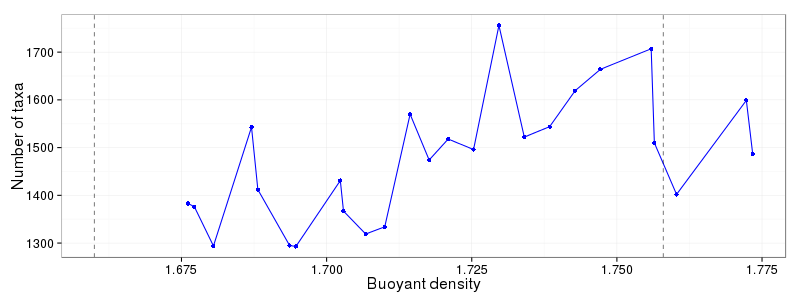

In [474]:
%%R -w 800 -h 300 

## dataframe
df.OTU = physeq.SIP.core %>% otu_table %>%
    as.matrix %>% as.data.frame
df.OTU$OTU = rownames(df.OTU)
df.OTU = df.OTU %>%    
    gather(sample, abundance, 1:(ncol(df.OTU)-1)) %>%
    group_by(sample) %>%
    summarize(n_taxa = sum(abundance > 0)) %>%
    ungroup()

df.OTU.real = inner_join(df.OTU, physeq.SIP.core.m, c('sample' = 'X.Sample')) 

## plotting
p = ggplot(df.OTU.real, aes(Buoyant_density, n_taxa)) +
    geom_point(color='blue') +
    geom_line(color='blue') +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density', y='Number of taxa') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p

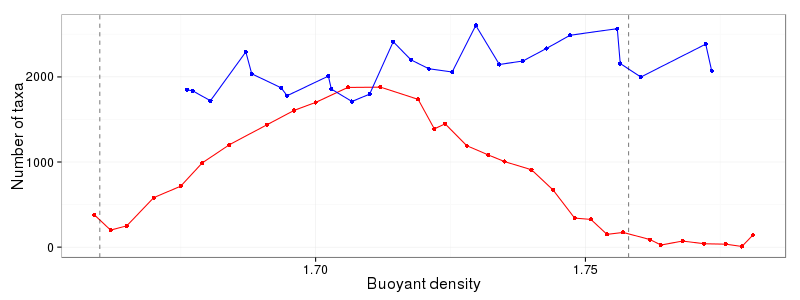

In [79]:
%%R -w 800 -h 300
OTU.table.dir = '/home/nick/notebook/SIPSim/dev/fullCyc/frag_norm_9_2.5_n5/default_run/1/'
OTU.table.file = 'OTU_abs5e9.txt'

# loading file
F = file.path(OTU.table.dir, OTU.table.file)
df.OTU = read.delim(F, sep='\t')

## edit table
df.OTU.nt = df.OTU %>%
    filter(count > 0) %>%
    group_by(library, BD_mid) %>%
    summarize(n_taxa = n())

## plot
p = ggplot(df.OTU.nt, aes(BD_mid, n_taxa)) +
    geom_point(color='red') +
    geom_line(color='red') +
    geom_point(data=df.OTU.real, aes(x=Buoyant_density), color='blue') +
    geom_line(data=df.OTU.real, aes(x=Buoyant_density), color='blue') +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density', y='Number of taxa') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p

### Normalized by max n-taxa

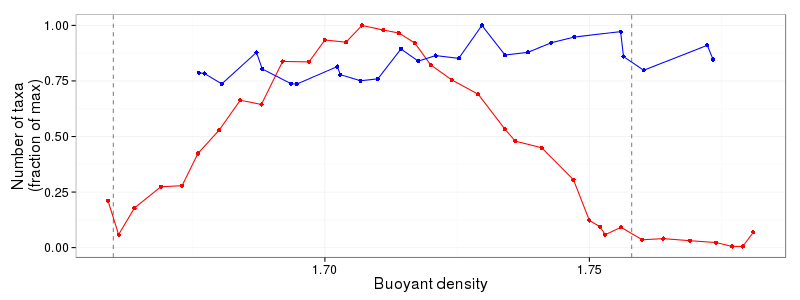

In [491]:
%%R -w 800 -h 300

## edit table
df.OTU.nt = df.OTU.nt %>%
    group_by() %>%
    mutate(n_taxa_norm = n_taxa / max(n_taxa))

df.OTU.real = df.OTU.real %>%
    group_by() %>%
    mutate(n_taxa_norm = n_taxa / max(n_taxa))


## plot
p = ggplot(df.OTU.nt, aes(BD_mid, n_taxa_norm)) +
    geom_point(color='red') +
    geom_line(color='red') +
    geom_point(data=df.OTU.real, aes(x=Buoyant_density), color='blue') +
    geom_line(data=df.OTU.real, aes(x=Buoyant_density), color='blue') +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density', y='Number of taxa\n(fraction of max)') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p

# Simulating PCR 

In [668]:
!cd $work_dir; \
    SIPSim OTU_PCR \
    OTU_abs5e9.txt \
    > OTU_abs5e9_PCR.txt
    
!cd $work_dir; \
    head -n 4 OTU_abs5e9_PCR.txt

library	taxon	fraction	BD_min	BD_mid	BD_max	count	rel_abund
1	OTU.1	-inf-1.660	-inf	1.659	1.659	0	0.0
1	OTU.1	1.660-1.662	1.66	1.661	1.662	0	0.0
1	OTU.1	1.662-1.667	1.662	1.664	1.667	0	0.0


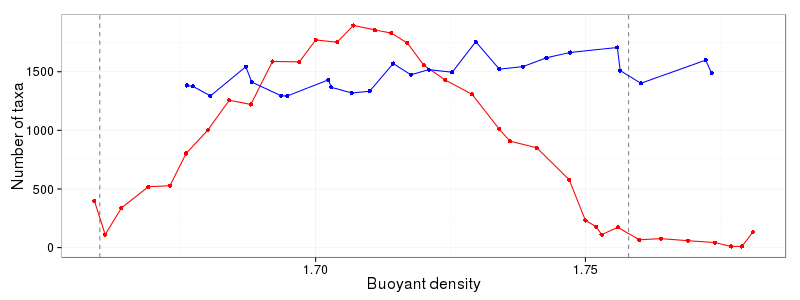

In [670]:
%%R -w 800 -h 300 -i work_dir
# plotting number of taxa at each BD
setwd(work_dir)

# loading file
df.OTU = read.delim('OTU_abs5e9_PCR.txt', sep='\t')

## edit table
df.OTU.nt = df.OTU %>%
    filter(count > 0) %>%
    group_by(library, BD_mid) %>%
    summarize(n_taxa = n())

## plot
p = ggplot(df.OTU.nt, aes(BD_mid, n_taxa)) +
    geom_point(color='red') +
    geom_line(color='red') +
    geom_point(data=df.OTU.real, aes(x=Buoyant_density), color='blue') +
    geom_line(data=df.OTU.real, aes(x=Buoyant_density), color='blue') +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density', y='Number of taxa') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p

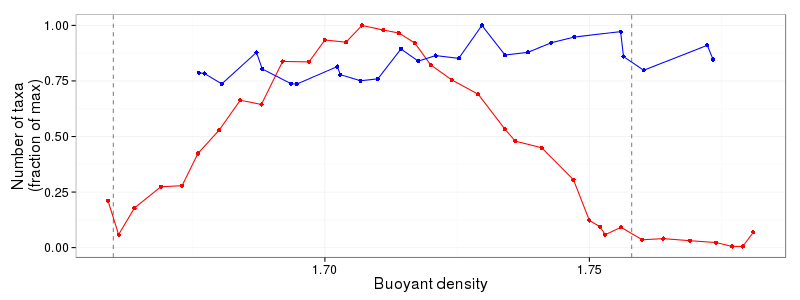

In [671]:
%%R -w 800 -h 300

## edit table
df.OTU.nt = df.OTU.nt %>%
    group_by() %>%
    mutate(n_taxa_norm = n_taxa / max(n_taxa))

df.OTU.real = df.OTU.real %>%
    group_by() %>%
    mutate(n_taxa_norm = n_taxa / max(n_taxa))


## plot
p = ggplot(df.OTU.nt, aes(BD_mid, n_taxa_norm)) +
    geom_point(color='red') +
    geom_line(color='red') +
    geom_point(data=df.OTU.real, aes(x=Buoyant_density), color='blue') +
    geom_line(data=df.OTU.real, aes(x=Buoyant_density), color='blue') +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density', y='Number of taxa\n(fraction of max)') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p

# Subsampling from the OTU table

In [672]:
dist,loc,scale = seq_per_fraction

!cd $work_dir; \
    SIPSim OTU_subsample \
    --dist $dist \
    --dist_params mean:$loc,sigma:$scale \
    --walk 4 \
    --min_size 10000 \
    --max_size 80000 \
    OTU_abs5e9_PCR.txt \
    > OTU_abs5e9_PCR_sub.txt 
    
!cd $work_dir; \
    head -n 4 OTU_abs5e9_PCR_sub.txt   

library	fraction	taxon	BD_min	BD_mid	BD_max	count	rel_abund
1	-inf-1.660	OTU.1	-inf	1.659	1.659	0	0.0
1	1.660-1.662	OTU.1	1.66	1.661	1.662	0	0.0
1	1.662-1.667	OTU.1	1.662	1.664	1.667	0	0.0


### Plotting sample size distribution

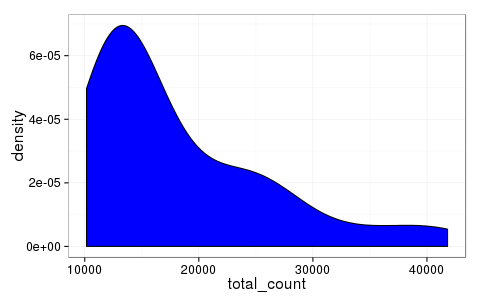

In [673]:
%%R -h 300 -i work_dir
setwd(work_dir)

tbl = read.csv('OTU_abs5e9_PCR_sub.txt', sep='\t') 

tbl.s = tbl %>% 
    group_by(library, fraction) %>%
    summarize(total_count = sum(count)) %>%
    ungroup() %>%
    mutate(library = as.character(library))

ggplot(tbl.s, aes(total_count)) +
    geom_density(fill='blue') +
    theme_bw() +
    theme( text = element_text(size=16) )

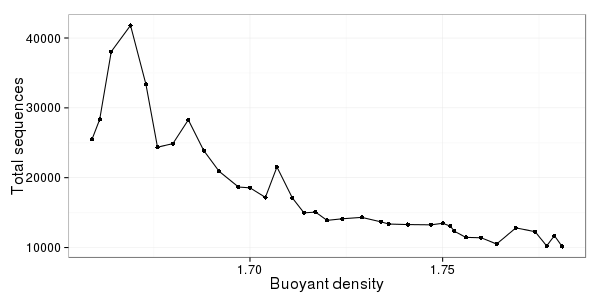

In [674]:
%%R -h 300 -w 600 -i work_dir
setwd(work_dir)

tbl = read.csv('OTU_abs5e9_PCR_sub.txt', sep='\t') 

tbl.s = tbl %>%
    group_by(fraction, BD_min, BD_mid, BD_max) %>%
    summarize(total_count = sum(count)) 

ggplot(tbl.s, aes(BD_mid, total_count)) +
    geom_point() +
    geom_line() +
    labs(x='Buoyant density', y='Total sequences') +
    theme_bw() +
    theme(
        text = element_text(size=16)
        )

## Plotting taxon abundances

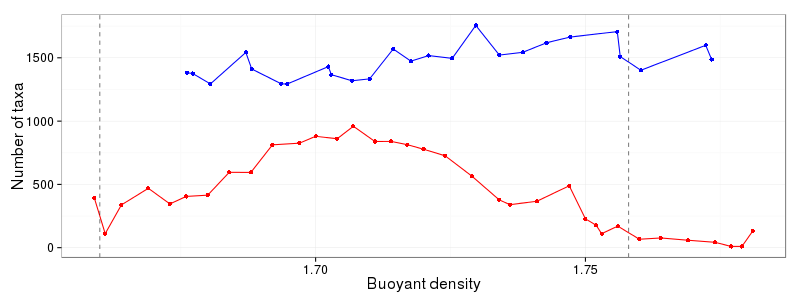

In [606]:
%%R -w 800 -h 300 -i work_dir
# plotting number of taxa at each BD
setwd(work_dir)

# loading file
df.OTU = read.delim('OTU_abs5e9_PCR_sub.txt', sep='\t')

## edit table
df.OTU.nt = df.OTU %>%
    filter(count > 0) %>%
    group_by(library, BD_mid) %>%
    summarize(n_taxa = n())

## plot
p = ggplot(df.OTU.nt, aes(BD_mid, n_taxa)) +
    geom_point(color='red') +
    geom_line(color='red') +
    geom_point(data=df.OTU.real, aes(x=Buoyant_density), color='blue') +
    geom_line(data=df.OTU.real, aes(x=Buoyant_density), color='blue') +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density', y='Number of taxa') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p

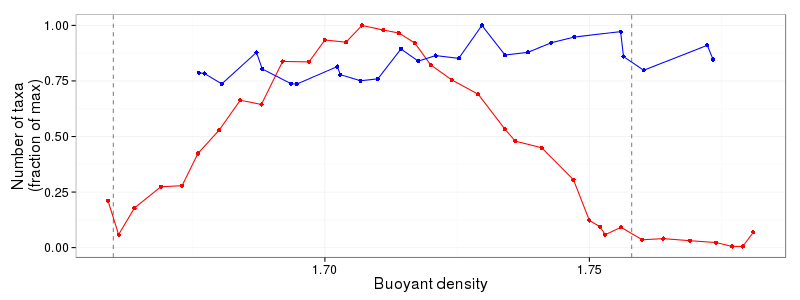

In [675]:
%%R -w 800 -h 300

## edit table
df.OTU.nt = df.OTU.nt %>%
    group_by() %>%
    mutate(n_taxa_norm = n_taxa / max(n_taxa))

df.OTU.real = df.OTU.real %>%
    group_by() %>%
    mutate(n_taxa_norm = n_taxa / max(n_taxa))


## plot
p = ggplot(df.OTU.nt, aes(BD_mid, n_taxa_norm)) +
    geom_point(color='red') +
    geom_line(color='red') +
    geom_point(data=df.OTU.real, aes(x=Buoyant_density), color='blue') +
    geom_line(data=df.OTU.real, aes(x=Buoyant_density), color='blue') +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density', y='Number of taxa\n(fraction of max)') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p

# Adding count error

In [571]:
!cd $work_dir; \
    SIPSim OTU_add_error \
    OTU_abs5e9_PCR_sub.txt \
    > OTU_abs5e9_PCR_sub_negBin.txt 
    
!cd $work_dir; \
    head -n 4 OTU_abs5e9_PCR_sub_negBin.txt 

library	fraction	taxon	BD_min	BD_mid	BD_max	count	rel_abund
1	-inf-1.660	OTU.1	-inf	1.659	1.659	0	0.0
1	1.660-1.662	OTU.1	1.66	1.661	1.662	0	0.0
1	1.662-1.667	OTU.1	1.662	1.664	1.667	0	0.0


## Plotting taxon abundances

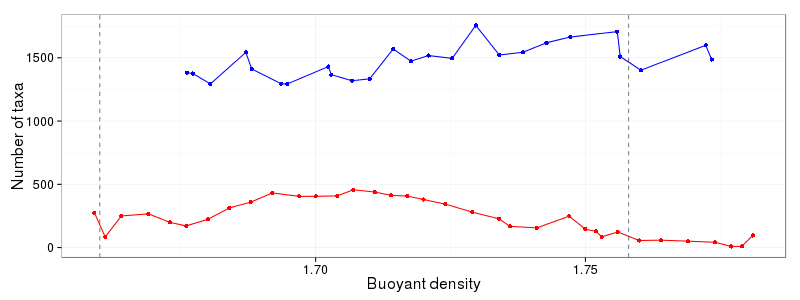

In [572]:
%%R -w 800 -h 300 -i work_dir
# plotting number of taxa at each BD
setwd(work_dir)

# loading file
df.OTU = read.delim('OTU_abs5e9_PCR_sub_negBin.txt', sep='\t')

## edit table
df.OTU.nt = df.OTU %>%
    filter(count > 0) %>%
    group_by(library, BD_mid) %>%
    summarize(n_taxa = n())

## plot
p = ggplot(df.OTU.nt, aes(BD_mid, n_taxa)) +
    geom_point(color='red') +
    geom_line(color='red') +
    geom_point(data=df.OTU.real, aes(x=Buoyant_density), color='blue') +
    geom_line(data=df.OTU.real, aes(x=Buoyant_density), color='blue') +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density', y='Number of taxa') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p

### Normalized by max n-taxa

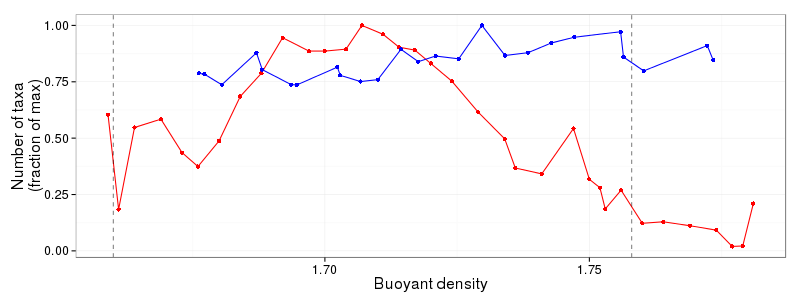

In [573]:
%%R -w 800 -h 300

## edit table
df.OTU.nt = df.OTU.nt %>%
    group_by() %>%
    mutate(n_taxa_norm = n_taxa / max(n_taxa))

df.OTU.real = df.OTU.real %>%
    group_by() %>%
    mutate(n_taxa_norm = n_taxa / max(n_taxa))


## plot
p = ggplot(df.OTU.nt, aes(BD_mid, n_taxa_norm)) +
    geom_point(color='red') +
    geom_line(color='red') +
    geom_point(data=df.OTU.real, aes(x=Buoyant_density), color='blue') +
    geom_line(data=df.OTU.real, aes(x=Buoyant_density), color='blue') +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density', y='Number of taxa\n(fraction of max)') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p